# MA755 College Scoreboard

Data Source:  https://collegescorecard.ed.gov/data  

Group Members: Stacy Li, Michelle Zhao, Sylvia Gao

# Table of Content

[1.Summary](#summary)  
      [1.1 Background](#background)  
      
[2.Data Import](#dataimport)   
      [2.1 Read Data](#readdata)   
      [2.2 Select Variable](#selectvar)   
     
[3.Data Exploration](#dataexplore)    
      [3.1 Looking for Pattern](#lookingforpattern)     
      [3.2 Split data](#splitdata)   
      [3.3 Looking for Correlation](#lookingforcorrelation)  

[4.Data Preparation](#dataprepare)    
      [4.1 Data Cleaning](#datacleaning)     
      [4.2 Encode Categorical Variable](#encode)   
      [4.3 Transformation Pipeline](#Transformation)  
      
[5.Train and Select model](#model)    
      [5.1 Linear Regression Model](#linear)     
      [5.2 Decision Tree Model](#decisiontree)   
      [5.3 Random Forest Model ](#randomforest)
      
[6.Fine-tune the best model](#tune)   
      [6.1 Build a Search Grid](#grid)     
      [6.2 Best Hyperparameters](#parameter)  
      [6.3 Feature Importance](#feature) 


       

# 1. Summary <a id='summary'></a>

In order to answer the question "What factors can be used to predict post-graduation earnings for college students?", we conduct a study on the College Scoreboard data downloaded from US Deparment of Education's website. The whole project can be divided into 5 parts:

**Data import**: This part includes importing the data, selecting variables, and briefly checking missing values.
    
**Data exploration**: In this part, we get general statistical summary for the selected variables and create histogram and scatter plot to study the pattern and the distribution of data. Then we split data into training dataset and testing dataset and calculate coefficient correlations before build regression model.
    
**Data preparation**: Then we need to prepare a clean dataset, which requires us to impute missing values and convert categorical variables to dummy variables. We also create a pipeline to accommodate all the estimators and execute them in a sequence before build the models.
    
**Train and select models** :In this part, we build linear regression model, decision tree  model and random forest model. We also evaluate the models on test dataset to compare the model performance.

**Fine-tune the best model**:
After selecting the model with the best performance, we fine-tune hyperparameters of this model to make the model perform better.

## 1.1 Background <a id='background'></a>

In the College Scoredcard Data, there is a great deal of earnings variation among all schools. It will be very helpful to study the factors that might influence college graduates' median earning after 10 years they enrolled the school program. 
We use the csv file for 2012-2013, which is the most recent dataset that contains earning information.

# 2. Data Import <a id='dataimport'></a>

## 2.1 Read Data <a id='readdata'></a>

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

Missing values in the dataset are indicated by `NULL`. However, since we have no way to know the information in the cell labeled as `PrivacySuppressed`, we also include it in NA values.

In [2]:
data = pd.read_csv("MERGED2012_13_PP.csv", header = 0, na_values = ["NULL","PrivacySuppressed"])

In [3]:
data.head() #take a look

,﻿UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,NaN,0.000000,1133.0,NaN,NaN,1,0.4879,0.5121,1405.0,1574.0
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,NaN,0.290236,1485.0,NaN,NaN,1,0.4200,0.5800,3153.0,3481.0
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,NaN,0.000000,1.0,NaN,NaN,1,0.4379,0.5621,264.0,336.0
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,NaN,0.307116,801.0,NaN,NaN,1,0.5425,0.4575,1208.0,1392.0
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,NaN,0.000000,1298.0,NaN,NaN,1,0.4046,0.5954,1951.0,1961.0


## 2.2 Select variable <a id='selectvar'></a>

The goal of our analysis is to build a model to predict students' earnings in the long term. So among all variables about earnings, we select **Median Earning 10 Years after Entry** as our target variable. Given target variable we would like to predict,we manually selected 10 variables, with one or two in each category, that may be predictive.

In [4]:
#only select 10 variables that interest us
data_filter = data[['UNITID',"OPEID","MD_FAMINC", "WDRAW_DEBT_MDN" , "PREDDEG", "STABBR",
"NPT4_PUB", "NPT4_PRIV", "PAR_ED_PCT_1STGEN", "DEP_STAT_PCT_IND", "PCTFLOAN", "MD_EARN_WNE_P10", "CONTROL"]]

Net price(estimated cost minus granted scholarship) is used to measure living cost for students in each school. But the net price information for public school and private school is recorded separatly in two mutually exclusive columns in the original dataset, so we combine these two columns together to create a variable **NPT4_COMBINE**.

In [5]:
#combine netprice for public school and private school together
data_filter['NPT4_COMBINE'] =  data_filter['NPT4_PRIV']  
data_filter.loc[data_filter['NPT4_COMBINE'].isnull(),'NPT4_COMBINE'] =  data_filter.loc[data_filter['NPT4_COMBINE'].isnull(),'NPT4_PUB']
data_filter.drop(["NPT4_PUB","NPT4_PRIV"],axis = 1, inplace = True)

In [6]:
#rename columns
data_filter.columns = ['CampusID', 'InstitutionID','MedianFamilyIncome','DebtNonCompleter',
                      'PredominantDegree','State','FirstGen','IndPerc','LoanPerc','MDEarning10','Control','NetPrice']

We replace the encoded values of PredominantDegree and Control with their actual values to make them more readable.

In [7]:
data_filter['PredominantDegree'] = data_filter['PredominantDegree'].map({0: 'Not classfied',1:'Certificate-degree',2:'Associate-degree',3:'Bachelor-degree',4:'Graduate-degree'})

In [8]:
data_filter['Control'] = data_filter['Control'].map({1:'Public',2:'Private nonprofit',3:'Private for-profit'})

Since our goal is to predict **Median Income 10 Years after Entry**, so we remove rows with missing values in this column.

In [9]:
non_missing = data_filter.loc[~data_filter["MDEarning10"].isnull(),:]

Below lists the variables and their corresponding missing rates in the final dataset we are going to use. DebtNonCompleter and NetPrice have the most missing values, which account for about 10% of the number of total records.

In [10]:
#missing rate of each variable
non_missing.isnull().mean()*100

CampusID               0.000000
InstitutionID          0.000000
MedianFamilyIncome     0.462810
DebtNonCompleter      10.429752
PredominantDegree      0.000000
State                  0.000000
FirstGen               3.702479
IndPerc                2.082645
LoanPerc               7.140496
MDEarning10            0.000000
Control                0.000000
NetPrice              10.561983
dtype: float64

**Here are all variables we select for the study:**

1.`CampusID`:             The ID of Campus

2.`InstituionID`:         Unit ID for institution

3.`MedianFamilyIncome`:   The median family income for the students

4.`DebtNonCompleter`:     The number of students who didn't compelete the debt

5.`PredominantDegree`:    The type of perdominant degree for the institution: 
0	Not classified
1	Predominantly certificate-degree granting
2	Predominantly associate's-degree granting
3	Predominantly bachelor's-degree granting
4	Entirely graduate-degree granting

6.`State`:                The state of institutions

7.`FirstGen`:             The percentage of students who are the first generation to be highly educated in their family

8.`IndPerc`:              Percent of financial independent student

9.`LoanPerc`:             The percentage of students who have loan.

10.`MDEarning10`:         (Target)The median earning of students after 10 years they enrolled in the program.

11.`Control`:             Control of institution: 
1   Public
2   Private nonprofit 
3   Private for-profit

12.`NetPrice`:            Average net price for institutions

# 3.Data Exploration <a id='dataexplore'></a>
In this part, we will explore the selected variables and get intuitive insights for the pattern of data.

## 3.1 Looking for patterns <a id='lookingforpattern'></a>

Let's first take a quick glance at the dataset for selected variables.

In [11]:
#Get quick discription of the data:
data_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7793 entries, 0 to 7792
Data columns (total 12 columns):
CampusID              7793 non-null int64
InstitutionID         7793 non-null int64
MedianFamilyIncome    7505 non-null float64
DebtNonCompleter      6190 non-null float64
PredominantDegree     7793 non-null object
State                 7793 non-null object
FirstGen              6777 non-null float64
IndPerc               7093 non-null float64
LoanPerc              7041 non-null float64
MDEarning10           6050 non-null float64
Control               7793 non-null object
NetPrice              6660 non-null float64
dtypes: float64(7), int64(2), object(3)
memory usage: 730.7+ KB


In [12]:
data_filter.head()

,CampusID,InstitutionID,MedianFamilyIncome,DebtNonCompleter,PredominantDegree,State,FirstGen,IndPerc,LoanPerc,MDEarning10,Control,NetPrice
0,100654,100200,22681.34069,10064.0,Bachelor-degree,AL,0.369764,0.157669,0.7935,30300.0,Public,11726.0
1,100663,105200,35359.88195,8650.0,Bachelor-degree,AL,0.345912,0.330313,0.5529,39700.0,Public,15123.0
2,100690,2503400,18409.75222,5644.5,Bachelor-degree,AL,0.495726,0.907193,0.9679,40100.0,Private nonprofit,6927.0
3,100706,105500,33376.82879,8305.5,Bachelor-degree,AL,0.324873,0.378065,0.4787,45500.0,Public,11160.0
4,100724,100500,20444.53146,9500.0,Bachelor-degree,AL,0.403549,0.180830,0.8157,26600.0,Public,11029.0


Let's further explore characteristics of all these variables.
First, we take a look at the categorical variables:

There are ategorical variables: `Predominant Degree`, `Control`, and `State`.

In [13]:
data_filter["Control"].value_counts()

Private for-profit    3768
Public                2068
Private nonprofit     1957
Name: Control, dtype: int64

In [14]:
data_filter["PredominantDegree"].value_counts()

Certificate-degree    3371
Bachelor-degree       2129
Associate-degree      1555
Not classfied          408
Graduate-degree        330
Name: PredominantDegree, dtype: int64

In [15]:
data_filter["State"].value_counts().head()

CA    797
TX    476
NY    464
FL    435
PA    416
Name: State, dtype: int64

In [16]:
#Show summary describe of numerical variables
data_filter[['MedianFamilyIncome','DebtNonCompleter',
                     'FirstGen','IndPerc','LoanPerc','MDEarning10','NetPrice']].describe()

,MedianFamilyIncome,DebtNonCompleter,FirstGen,IndPerc,LoanPerc,MDEarning10,NetPrice
count,7505.000000,6190.000000,6777.000000,7093.000000,7041.000000,6050.000000,6660.000000
mean,25963.839578,5998.863005,0.480788,0.559266,0.536472,32930.661157,15263.235435
std,18824.305471,2415.623018,0.121651,0.233077,0.292615,14561.332554,7604.883823
min,0.000000,603.000000,0.068720,0.007263,0.000000,9500.000000,-19360.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,155606.577100,27625.000000,0.952494,0.985639,1.000000,233100.000000,87414.000000


We can see from the summary table that all the percentile values are missing for numerical variables, which means all the numerical variables have missing value. This can also be seen from the count and the missing rate we calculated before. Also, we can see the range for variables `MedianFamilyIncome`, `DebtNonCompleter`, `MDEarning10` and `NetPrice` are large, especially for `NetPrice`. The minimum value is negative, which is -$19,369. 

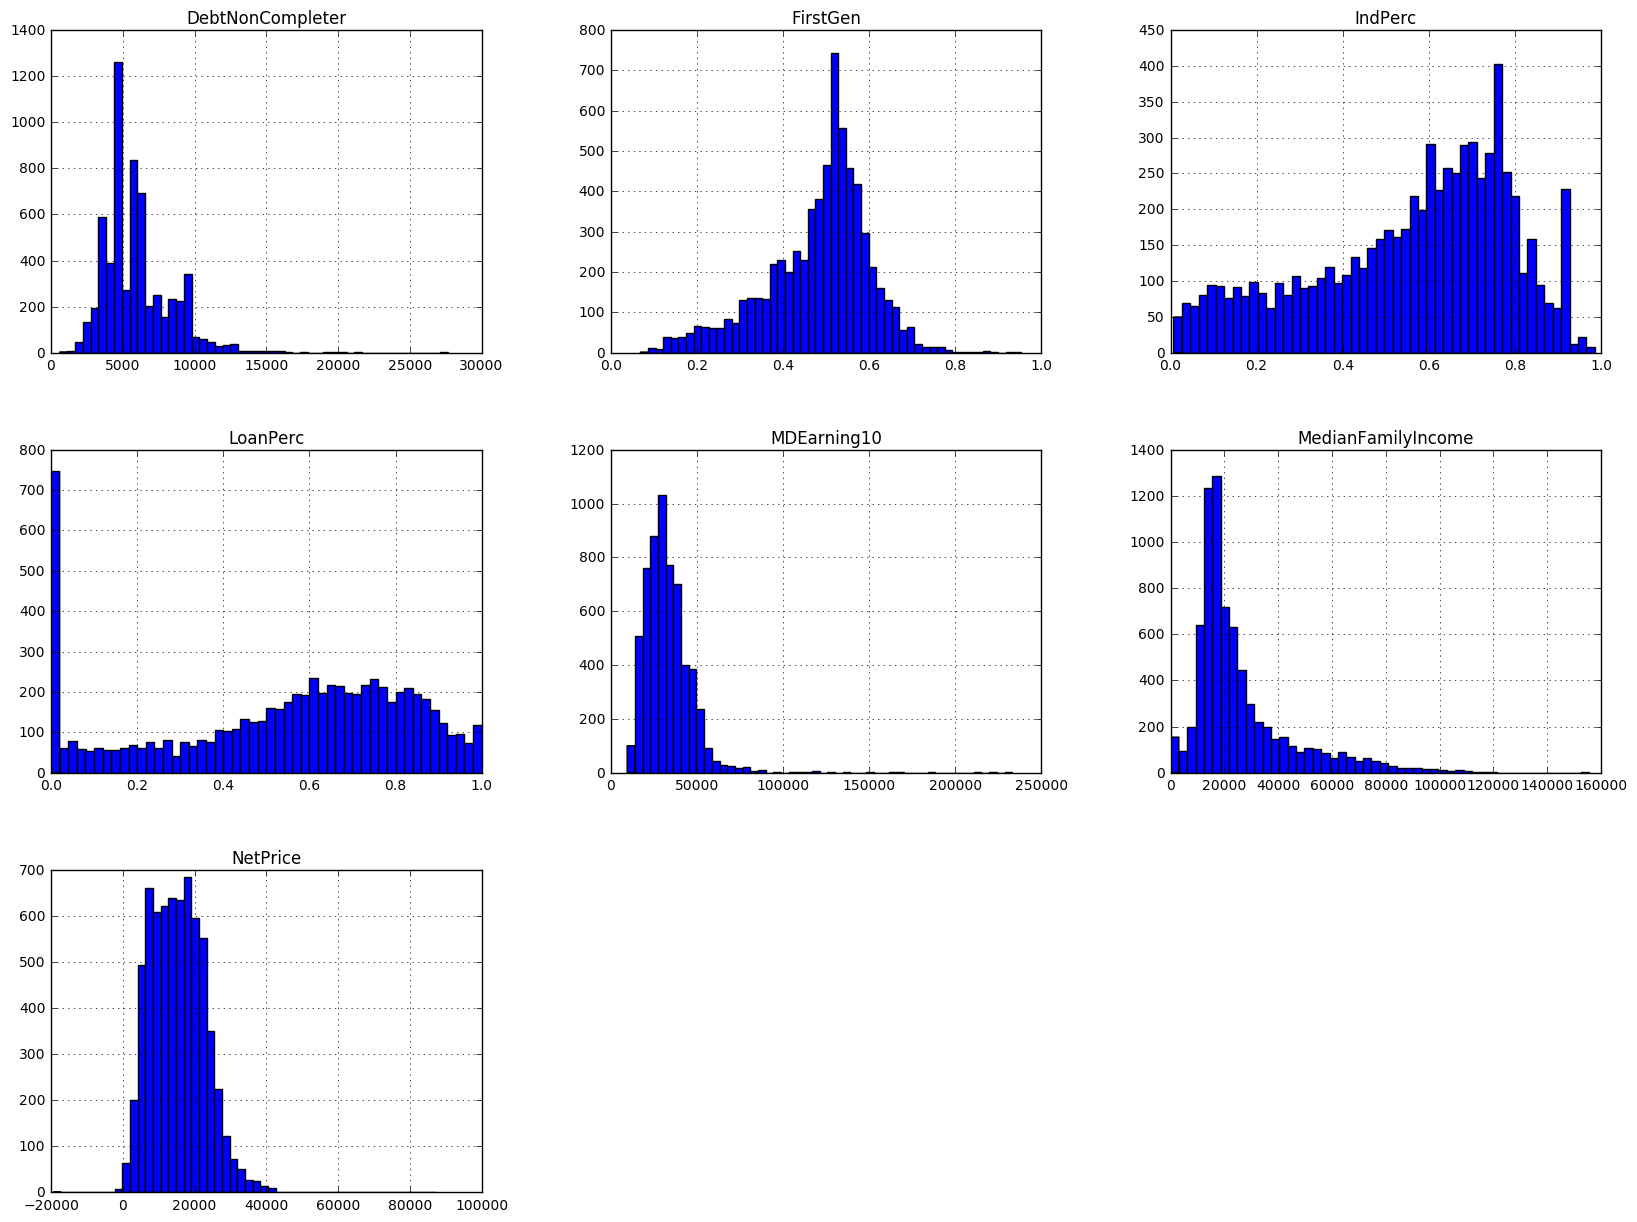

In [17]:
#set up matplotlib using jupyter backend so that we don't have to call the plot show every time
%matplotlib inline 
import matplotlib.pyplot as plt
#plot histogram with 50 bins within each plot.
data_filter[['MedianFamilyIncome','DebtNonCompleter',
                     'FirstGen','IndPerc','LoanPerc','MDEarning10','NetPrice']].hist(bins=50, figsize=(20,15))
plt.show()

From the histogram of all the numerical variables, we can see that none of these variables is normally distributed. Also, it is vary important to notice that the distribution for variable `MDEarning10`, `MedianFamilyIncome` and `NetPrice` are similar right-tailed. Also, the distribution for the variable `FirstGen`, `IndPerc` and `LoanPerc` are left-tailed. 

We also need to notice that, from the histogram of variable `LoanPerc`, there is a peak at 0.0 percentage. This indicates that for some of the insitutions, there is no students take loan for the reasons.

###### Then lets take a look at the histogram for the categorical variables.

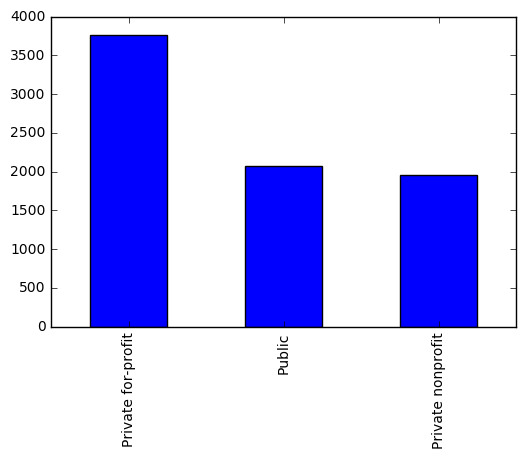

In [18]:
data_filter["Control"].value_counts().plot(kind='bar');

From the histogram of variable `Control` we can see around half of the institutions are private for-profit schools.

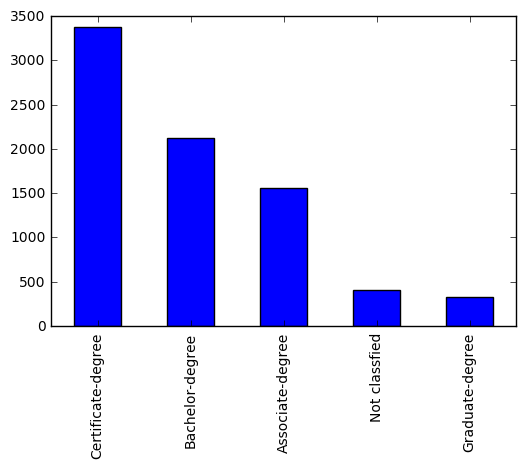

In [19]:
data_filter["PredominantDegree"].value_counts().plot(kind='bar');

And for the type of predominant degree for the institutions, most of the schools offer certificate degree as their predominant degree.

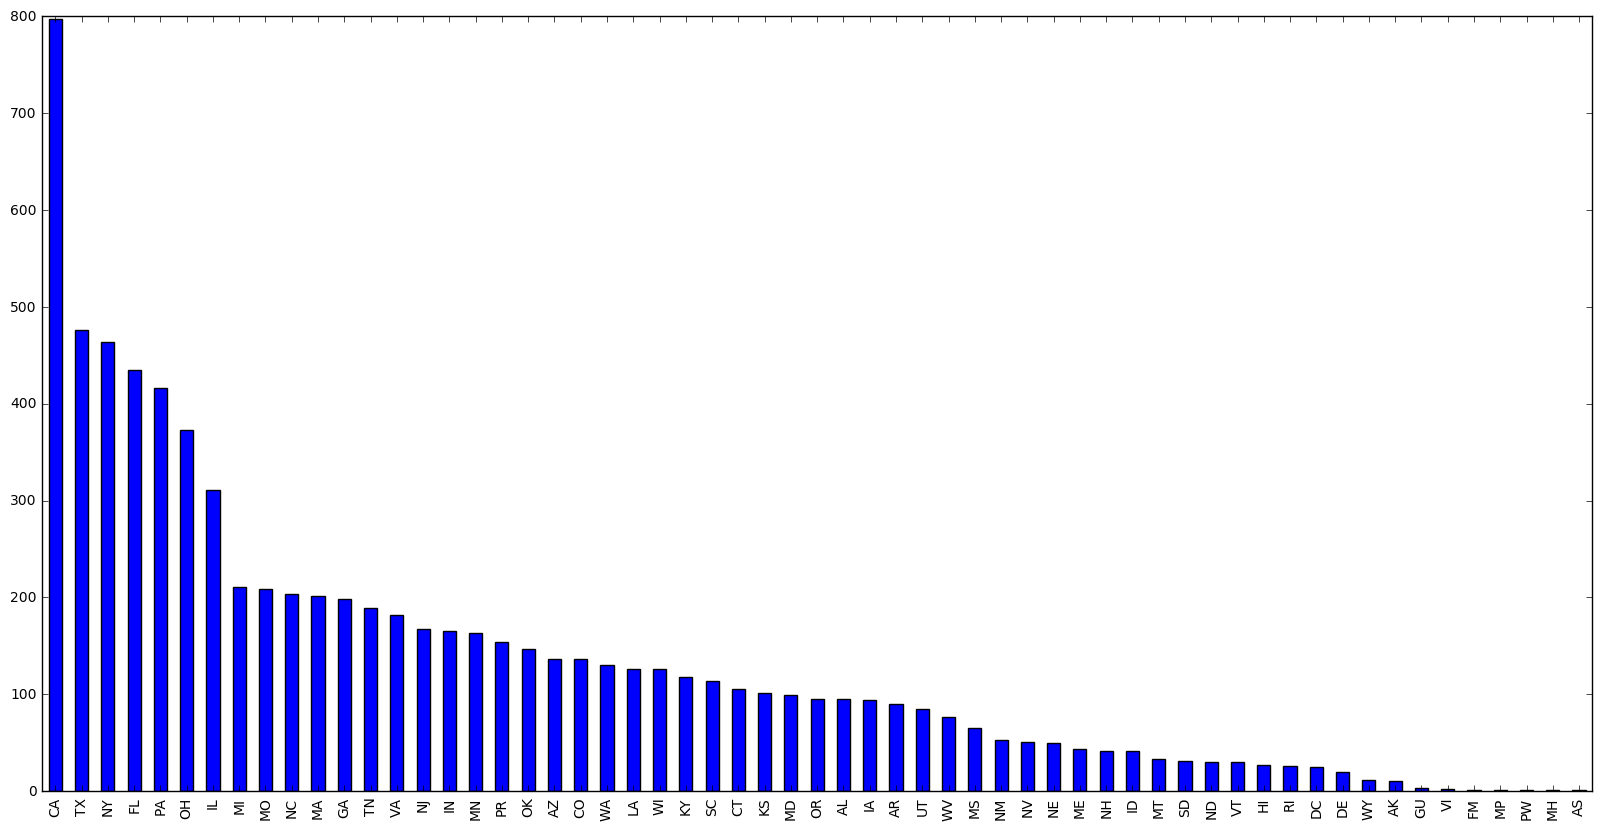

In [20]:
data_filter["State"].value_counts().plot(kind='bar',figsize=(20,10));

If we take a look at the `State` variable and counts for institutions, it is obvious that California has the most institutions, followed by the Texas, New York, Florida, Ohio and Illinois. 

## 3.2 Split Data <a id='splitdata'></a>

In [21]:
#import hashlib package
import hashlib

#define test_set_check function to compute a hash of each instance's indentifier
def test_set_check(identifier, test_ratio, hash):
    #put the instance in the test set if the value is lower or equal to 51=20%*256
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

#Get the test and traning dataset based on the result of test_set_check() function
def split_train_test_by_id(data_filter, test_ratio, id_column, hash=hashlib.md5):
    ids = data_filter[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash=hashlib.md5))
    return data_filter.loc[~in_test_set], data_filter.loc[in_test_set]

In [22]:
#split training dataset and test dataset by the newly created id column
np.random.seed(123)
train_set, test_set = split_train_test_by_id(non_missing, 0.2, "CampusID")

## 3.3 Looking for Correlations on train data set  <a id='lookingforcorrelation'></a>

After we have a brief study of the dataset, we need to calculate correlations between variables. This part is a further study to give us a good insight of linear correlations between each pair of the variables. It is also very useful to study the linear correlations between the numerical variables and the target variables before we build any regression model.

In [23]:
#Create a copy of trainin dataset:
copy_data =train_set.copy()


In [24]:
#Compute the standard correlation coefficient between every pair of attributes.
corr_matrix = copy_data.corr()

In [25]:
#Create correlations with the earning after 10 years of enrollment value and assort the result by descending
corr_matrix["MDEarning10"].sort_values(ascending=False)

MDEarning10           1.000000
MedianFamilyIncome    0.546578
DebtNonCompleter      0.469191
NetPrice              0.375803
LoanPerc              0.123027
InstitutionID         0.050708
CampusID              0.031169
IndPerc              -0.289751
FirstGen             -0.552881
Name: MDEarning10, dtype: float64

The variable `MedianFamilyIncome` and `DebtNonCompleter` have strong positive relationship with `MDEarning10`; and the variable `FirstGen` has strong negative relationship with variable `MDEarning10`. This indicates the students from the highly educated family might have higher income after graduation.

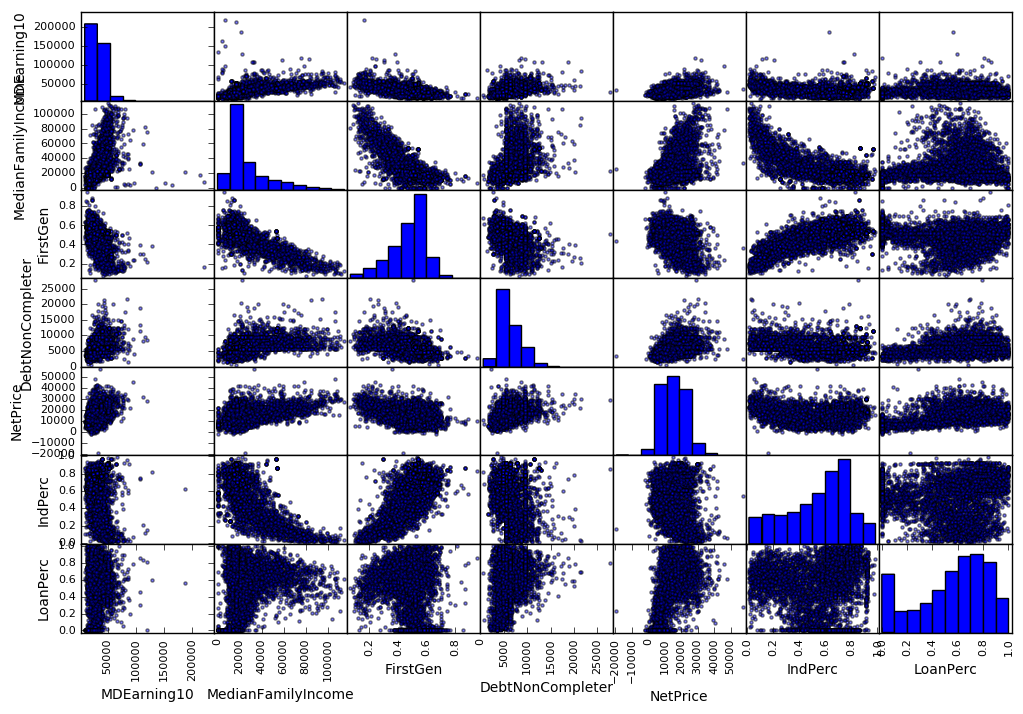

In [26]:
#import scatter_matrix function from Pandas package.
from pandas.tools.plotting import scatter_matrix

#only select numerical variables and create scatter plot for every pairs 
attributes = ["MDEarning10", "MedianFamilyIncome", "FirstGen",
              "DebtNonCompleter","NetPrice","IndPerc","LoanPerc"]
#Create scatter matrix with size 12:8
scatter_matrix(copy_data[attributes], figsize=(12, 8));

The plot matrix shows coefficient correlations between each pairs of variables. The diagnoal from right top to the left bottom is the histogram for the variables. 

From the scatter matrix we can see there are a lot of variables shows a strong correlation with each other. For example, the variable `FirstGen` and `MedianFamilyIncome` have strong negative relationship from the scatter plot. 

As for the target variable `MDEarning10`, almost all other variables have relationship with our target variable, which means we do not need to get rid of any numerical variables before we build the models.

# 4. Data Preparation <a id='dataprepare'></a>

After doing some exploratory analysis, we have gained some insights into the dataset and identify several variables that may be useful for prediction such as median family income and degree type. Before proceeding to the modeling stage, we need to first prepare a clean dataset, which requires us to deal with missing values and convert categorical variables to dummy variables.


First we separate predictors and target variables into two dataset.

In [27]:
college = train_set.drop("MDEarning10", axis=1) #drop this column
college_labels = train_set["MDEarning10"].copy()
print(college.shape)
print(college_labels.shape)

(4807, 11)
(4807,)


## 4.1 Data Cleaning <a id='datacleaning'></a>

After getting two separate datasets for predictors and response variable. We can start off with data cleaning. Here, we decide to use median value of the column to replace missing values.

In [28]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median') #create a empty transformer with specified strategy

`CampusID` and `InstitutionID` would be useless in prediction. So we drop these two columns.

In [29]:
college.drop(["CampusID","InstitutionID"], axis = 1, inplace = True)

We will only do imputation on numeric variable. So we need to drop categorical variables.

In [30]:
college_num = college.drop(['State', 'PredominantDegree','Control'], axis = 1) 

Then we fit the transformer to the dataset only containing numerical variables. Median value of each columns are estimated, which will later be used to perform transformation.

In [31]:
imputer.fit(college_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

Use the parameter estimated to perform transformation.

In [32]:
X = imputer.transform(college_num)

The output is a numpy array, so we need to convert is back to pandas dataframe.

In [33]:
college_tr = pd.DataFrame(X, columns = college_num.columns) #numeric columns after imputation

## 4.2 Encode Categorical Variables <a id='encode'></a>

There are three categorical variables in the dataset: **State**, **PredominantDegree** and **Control**. They are all nominal variables, so we use `LabelBinarizer` transformer to encode them into dummy variables. However, `LabelBinarized` can only accept one column as input, so we modify the transformer to allow multiple columns.

In [34]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()

In [35]:
college_cat = college[['State', 'PredominantDegree','Control']]

We create a custom transformer `EncodeCategorical` to allow us to code multiple categorical variables into dummies at the same time.

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None.
    """

    def __init__(self, columns=None):
        self.columns  = columns
        self.encoders = None

    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode.
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns

        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelBinarizer().fit(data[column])
            for column in self.columns
        }
        self.classes_ = {
            column:encoder.classes_
            for column, encoder in self.encoders.items()
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame.
        """
        output = np.empty([len(data),0])
        for column, encoder in self.encoders.items():
             ay = encoder.transform(data[column])
             output = np.concatenate((output, ay), axis = 1)
        return output

In [37]:
encoder = EncodeCategorical(columns = ['State', 'PredominantDegree','Control'])
college_cat_tr = encoder.fit_transform(college)

The output is a numpy array with a size (4807, 66). All variables are dummy variables.

In [38]:
college_cat_tr.shape

(4807, 66)

## 4.3 Transformation Pipeline <a id='Transformation'></a>

 Then we can create a Pipeline to accommodate all the estimators and execute them in a sequence, which would make the modeling process more automated and easy to manage. It should be noted that all but the last estimators should be transformers which have fit_transform() method. When we call fit_transform() method, the output of each estimators is fed into next estimator, until the end of pipeline.

We create a estimator used to select variables of the same type, so that we can divide the processing of numerical variables and categorical variabls into two pipelines.

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin): #include BaseEstimator and TransformerMixin as base class
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names 
    def fit(self, X, y=None):  #Don't have to estimate any parameter, so no action
        return self
    def transform(self, X):
        return X[self.attribute_names]

Now it's time to construct a full pipeline. The full pipeline consists of two parallel pipelines, one for categorical variables and one for numerical variables. At the beginning of each parallel pipeline, the `DataFrameSelector` is used to select only columns that we would like feed into the pipeline. At the end of pipeline, we use `FeatureUnion` function to combine two outputs together to form a clean dataset.

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

num_attribs = college_num.columns
cat_attribs = ['State', 'PredominantDegree','Control']

num_pipeline = Pipeline([
        ('selector',DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy = 'median')),
        ('std_scaler', StandardScaler()), 
    ])

cat_pipeline = Pipeline([
        ('select', DataFrameSelector(cat_attribs)),
        ('label_binarizer', EncodeCategorical())
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ('num_pipeline', num_pipeline),
        ('cat_pipeline', cat_pipeline),
    ])

In [41]:
college_prepared = full_pipeline.fit_transform(college) #Apply the full pipeline on the college data.
college_prepared.shape

(4807, 72)

The output of the pipelinw has a shape of (4807, 72)

# 5. Train and Select Models <a id='model'></a>

As we did several manipulation on the train data set. We need to do the same thing on the test data set in order to make prediction.

In [42]:
#Prepare the testing data
X_test = test_set.drop(["CampusID","InstitutionID","MDEarning10"], axis=1)
Y_test = test_set["MDEarning10"].copy()
X_test_prepared = full_pipeline.transform(X_test)

## 5.1 Linear Regression Model <a id='linear'></a>

Let's first train a linear regression model. There are three steps:  
    1.Build a linear regression model on the train data set, and evaluate model performance  
    2.Apply Cross-Validation to validate the performance of Linear Regression model  
    3.Evalate the linear regression model, by checking the RMSE on the test data set

### 5.1.1 Train a Linear Regression Model on  train data set

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#Train the model
lin_reg = LinearRegression()
lin_reg.fit(college_prepared, college_labels)

#Calculate RMSE on on the train data set
from sklearn.metrics import mean_squared_error
lin_reg_pred = lin_reg.predict(college_prepared)
lin_mse = mean_squared_error(college_labels, lin_reg_pred)
lin_rmse = np.sqrt(lin_mse)
# familiar way to understand model performance
rsqure = r2_score(college_labels, lin_reg_pred) 


print("RMSE of the Linear Regression model on the train dataset is " +  str(round(lin_rmse,2)))  #10029.67
print("R-squre of the Linear Regression model on the train dataset is " +  str(round(rsqure,2)))  #0.52


print("Average Median earnings is " +  str(round(college_labels.mean(),0)))
print("Minimum Median earnings is " +  str(round(college_labels.min(),0))) 
print("Maximum Median earnings is " +  str(round(college_labels.max(),0))) 

RMSE of the Linear Regression model on the train dataset is 10029.67
R-squre of the Linear Regression model on the train dataset is 0.52
Average Median earnings is 32928.0
Minimum Median earnings is 9500.0
Maximum Median earnings is 233100.0


We build a linear regression model on the train data set. RMSE of this model is 10,029. In the train set, the median earnings range from \$9,500 to \$233,100, and the average is \$32,928. A prediction error of \$10,000 seems to be acceptable. But R-squre of this model tells us that the accuracy is only 52%.

### 5.1.2 Cross-Validation

In [44]:
np.random.seed(123)
from sklearn.model_selection import cross_val_score
lin_score = cross_val_score(lin_reg, college_prepared, college_labels,scoring='neg_mean_squared_error',cv=10)
lin_rmse_cv = np.sqrt(-lin_score).mean()
print("Average RMSE of the Linear Regression model with Cross-Validation is " +  str(round(lin_rmse_cv,2))) #1.03009404639e+13


Average RMSE of the Linear Regression model with Cross-Validation is 1.03009404639e+13


With cross-validation we can see that RMSE gets larger. This means the linear regression model may have the problem of overfitting. Let's apply this model on the test data set to see how it performs.

### 5.1.3 Evaluation on test data set

In [45]:
lin_reg_pred_test = lin_reg.predict(X_test_prepared)
lin_mse_test = mean_squared_error(Y_test, lin_reg_pred_test)
lin_rmse_test = np.sqrt(lin_mse_test)
rsqure_test = r2_score(Y_test, lin_reg_pred_test) 
print("RMSE of the Linear Regression model on the test dataset is " +  str(round(lin_rmse_test,2)))  #9859.55
print("R-squre of the Linear Regression model on the test dataset is " +  str(round(rsqure_test,2)))  #0.56

RMSE of the Linear Regression model on the test dataset is 9859.55
R-squre of the Linear Regression model on the test dataset is 0.56


The linear regression model performs better on the test data set. But still, we should not be satisfied with this result. Therefore, we should consider other models.

## 5.2 Decision Tree Model <a id='decisiontree'></a>

Let's try a more powerful model, decision tree model, on the train data set. The basic steps are similar to what we did in the Linear Regression model.

### 5.2.1 Build a Decision Tree Model

In [46]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(college_prepared, college_labels)
tree_pred = tree_reg.predict(college_prepared)
tree_mse = mean_squared_error(college_labels, tree_pred)
tree_rmse = np.sqrt(tree_mse)

print("RMSE of the Decision Tree model on the train dataset is " +  str(round(tree_rmse,2)))   #2150.5

print("Average Median earnings is " +  str(round(college_labels.mean(),0)))
print("Minimum Median earnings is " +  str(round(college_labels.min(),0))) 
print("Maximum Median earnings is " +  str(round(college_labels.max(),0))) 

RMSE of the Decision Tree model on the train dataset is 2150.5
Average Median earnings is 32928.0
Minimum Median earnings is 9500.0
Maximum Median earnings is 233100.0


The decision tree model performs much better than the linear regression model. The RMSE is only 2,151. However, it is very easy for the decision tree model to be overfitting. Therefore, before we apply this model on the test data set. We'll do validation first. Now, we use the cross-validation technique on the model fitting process.

### 5.2.2 Cross-Validation

In [47]:
np.random.seed(123)
tree_score = cross_val_score(tree_reg, college_prepared,college_labels,scoring='neg_mean_squared_error',cv=10)
tree_rmse_cv = np.sqrt(-tree_score).mean()
print("Average RMSE of the Linear Regression model with Cross-Validation is " +  str(round(tree_rmse_cv,2))) #10725.15

Average RMSE of the Linear Regression model with Cross-Validation is 10725.15


Now the decision tree model has larger prediction error. However, this is still much better than that of the linear regression model. Therefore, we believe the decision tree model is better. Let's apply this model on the test data set to see if it is better than the linear regression model.

### 5.2.3 Evaluation on test data set

In [48]:
tree_reg_pred_test = tree_reg.predict(X_test_prepared)
tree_mse_test = mean_squared_error(Y_test, tree_reg_pred_test)
tree_rmse_test = np.sqrt(tree_mse_test)
print("RMSE of the Decision Tree model on the test dataset is " +  str(round(tree_rmse_test,2)))#10600.48

RMSE of the Decision Tree model on the test dataset is 10600.48


On the test data set, the decision tree model performs worse than the linear regression model. Before make the decision, let's try the last model Random Forest model.

## 5.3 Random Forest Model <a id='randomforest'></a>

Let's repeat the steps in the decision tree model.

### 5.3.1 Build a Random Forest Model

In [49]:
np.random.seed(123)
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(college_prepared, college_labels)
rf_pred = rf_reg.predict(college_prepared)
rf_mse = mean_squared_error(college_labels, rf_pred)
rf_rmse = np.sqrt(rf_mse)

print("RMSE of the Random Forest model on the train dataset is " +  str(round(rf_rmse,2)))  #4279.44

RMSE of the Random Forest model on the train dataset is 4279.44


On the train data set, RMSE of the random forest model is better than the linear regression model, but worse than the decision tree model. Let's apply the cross-validation to see whether or not the random forest model is over-fitting.

### 5.3.2 Cross-Validation

In [50]:
np.random.seed(123)
rf_score = cross_val_score(rf_reg, college_prepared,college_labels,scoring='neg_mean_squared_error',cv=10)
rf_rmse_cv = np.sqrt(-rf_score).mean()
print("Average RMSE of the Linear Regression model with Cross-Validation is " +  str(round(rf_rmse_cv,2)))  #9055.6

Average RMSE of the Linear Regression model with Cross-Validation is 9055.6


This score is better than the previous two models. It seems that the random forest model is very promising. Let's check its performance on the test data set.

### 5.3.3 Evaluation on test data set

In [51]:
rf_reg_pred_test = rf_reg.predict(X_test_prepared)
rf_mse_test = mean_squared_error(Y_test, rf_reg_pred_test)
rf_rmse_test = np.sqrt(rf_mse_test)
print("RMSE of the Decision Tree model on the test dataset is " +  str(round(rf_rmse_test,2))) # 8175.81

RMSE of the Decision Tree model on the test dataset is 8175.81


The random forest model has the smallest RMSE on test data, indicating the prediction error is only \$8,176. 

## 5.4 Model Selection

We've built three models and evaluated their performance on train data set and test data set. Cross-validation is also applied in the process. Now put all RMSE together

In [52]:
model_score = np.array([[lin_rmse,lin_rmse_cv,lin_rmse_test],[tree_rmse,tree_rmse_cv,tree_rmse_test],
                       [rf_rmse,rf_rmse_cv,rf_rmse_test]])
print(model_score)

[[  1.00296739e+04   1.03009405e+13   9.85954580e+03]
 [  2.15050401e+03   1.07251515e+04   1.06004789e+04]
 [  4.27944493e+03   9.05559680e+03   8.17580861e+03]]


From the output, we can see that random forest model performs the best on both train data set and test data set. In addition, average RMSE in the cross-validation process is relatively close to RMSE without validation. We can believe that the model is not overfitting. Therefore, we will use choose the random forest model as the best model.

# 6. Fine-tune the best model <a id='tune'></a>

## 6.1 Build a search grid  <a id='grid'></a>

We've chosen random forest model as our final model. We can further fine-tune hyperparameteres of this model to make the model perform better.

In [53]:
from sklearn.model_selection import GridSearchCV
np.random.seed(123) 
# define which hyperparameters and corresponding values we want to experiment
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [5, 10, 15, 20,]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 30], 'max_features': [5, 10, 15, 20]},
  ] 

rf_reg = RandomForestRegressor()

# search the best combination using 5-fold cross-validation
np.random.seed(123) 
grid_search = GridSearchCV(rf_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error') 

grid_search.fit(college_prepared, college_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [5, 10, 15, 20]}, {'bootstrap': [False], 'n_estimators': [3, 10, 30], 'max_features': [5, 10, 15, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

## 6.2 Best hyperparameters  <a id='parameter'></a>

In [54]:
grid_search.best_params_

{'max_features': 20, 'n_estimators': 30}

In [55]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    
    

10701.6374049 {'n_estimators': 3, 'max_features': 5}
11234.162305 {'n_estimators': 10, 'max_features': 5}
9554.47867714 {'n_estimators': 30, 'max_features': 5}
10662.3301715 {'n_estimators': 3, 'max_features': 10}
9550.3266314 {'n_estimators': 10, 'max_features': 10}
9635.44531374 {'n_estimators': 30, 'max_features': 10}
10989.1152064 {'n_estimators': 3, 'max_features': 15}
9746.64134694 {'n_estimators': 10, 'max_features': 15}
9238.38517592 {'n_estimators': 30, 'max_features': 15}
11534.3117897 {'n_estimators': 3, 'max_features': 20}
10289.7085259 {'n_estimators': 10, 'max_features': 20}
9156.71861999 {'n_estimators': 30, 'max_features': 20}
10697.211099 {'bootstrap': False, 'n_estimators': 3, 'max_features': 5}
9876.5371017 {'bootstrap': False, 'n_estimators': 10, 'max_features': 5}
9267.16478556 {'bootstrap': False, 'n_estimators': 30, 'max_features': 5}
11398.5091583 {'bootstrap': False, 'n_estimators': 3, 'max_features': 10}
9606.34051273 {'bootstrap': False, 'n_estimators': 10, '

According to the results, the random forest model will perform the best if we use 20 features to build 30 subtrees. But the question is which features should we use? We can take a look at the feature importances in the random forest model

## 6.3 Feature Importances  <a id='feature'></a>

In [56]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  2.01385318e-01,   8.62363487e-02,   7.31111613e-02,
         8.76437495e-02,   5.41967378e-02,   6.56897843e-02,
         8.94672254e-05,   2.07462430e-04,   5.19612787e-04,
         3.06256400e-06,   4.26730171e-03,   6.68429019e-03,
         7.90254084e-04,   1.60293675e-03,   4.52889059e-04,
         7.63003412e-05,   2.37136046e-03,   5.81072419e-06,
         7.83411962e-04,   3.18527886e-05,   1.09028458e-04,
         2.08629673e-04,   2.14434375e-04,   2.97558880e-03,
         5.35810207e-04,   4.25161494e-04,   3.03219151e-03,
         5.67116063e-03,   6.19964204e-03,   1.46272401e-03,
         3.01278367e-04,   7.71807553e-04,   1.16610171e-03,
         2.24523629e-03,   7.38659538e-06,   1.49590399e-04,
         7.56798050e-05,   1.16458147e-03,   2.57012837e-04,
         3.13751019e-04,   2.06283262e-03,   4.79587593e-03,
         1.56729091e-04,   1.07445845e-04,   1.33624327e-02,
         9.56360257e-04,   9.86034248e-04,   5.76842976e-04,
         3.96405753e-03,

We need to display these importance scores with their corresponding attribute names to have a full understanding. Let's add attributes names.

In [57]:
classes = list(encoder.classes_.values())

In [58]:
column_name = np.concatenate((np.array(college_num.columns),classes[0], classes[1], classes[2]),axis=0)

In [59]:
pd.DataFrame({'Column':column_name,'Importance':feature_importances}).sort(['Importance'], ascending = False)

,Column,Importance
0,MedianFamilyIncome,0.201385
67,Graduate-degree,0.104227
3,IndPerc,0.087644
1,DebtNonCompleter,0.086236
65,Bachelor-degree,0.082557
2,FirstGen,0.073111
5,NetPrice,0.065690
4,LoanPerc,0.054197
66,Certificate-degree,0.048422
69,Private for-profit,0.023479


Now we can see that, students earning after 10 years from entry is highly correlated with its median family Income, if he has a graduate degree, the percentage of students who are financially independent and the median debt for students who have not completed.

Median family income plays the key role. It is easy to understand. With family monetary support, it would be easier for students to focus on developing their interests and skills. They are also more likely to earn other degrees or certificates. In this way, these students could be more competitive in the job market.

